# **Computational and Numerical Methods Lab - 8**

```
Abhimanyu Karia: 202201435
Devarshi Patel : 202201447
```

# Linear piecewise interpolation
- It is a method used to estimate values between known data points.
- It involves connecting adjacent data points with straight lines, making it a simple way to approximate a function.
- For two points $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$, linear interpolation is given by:
    - 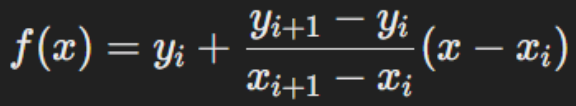

# Cubic spline

- Cubic spline interpolation is a method of constructing a smooth curve through a set of data points, ensuring that the curve is continuous and smooth at each point.
- It uses piecewise cubic polynomials between each pair of data points such that the curve is smooth overall up to the second derivative.
- Conditions for cubic spline:
    - s(x) is a polynomial of degree <=3 on each subinterval.
    - s(x), s'(x) and s"(x) are continuous for a<=x<=b
    - s"($x_1$)=s"($x_n$)=0
- Formula:
    - 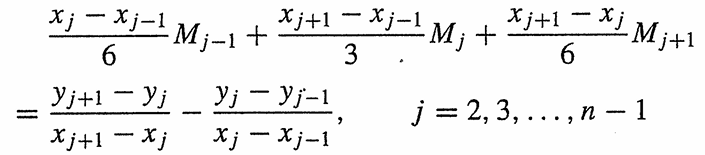
    - Find the values of $M_j$ 
    - Substitute the values of $M_j$ in 
    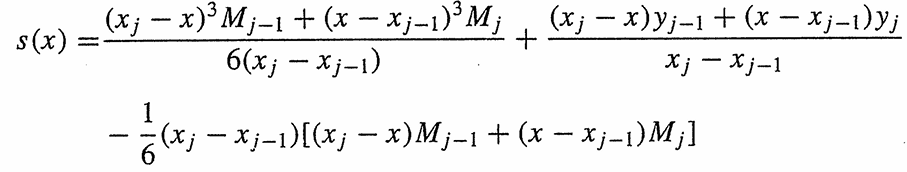

# Piecewise Linear vs Cubic Spline

- Cubic spline produces a smooth curve with continuous first and second derivatives across all intervals, making it ideal for applications where smoothness is crucial.
- Cubic spline is genrally more accurate because it considers the curvature between points.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class Interpolation:
    def __init__(self,matrix,function = None) -> None:
        self.function = function
        self.matrix = matrix
        self.err = 1e-2
    def mypolyint(self,matrix,plot_poly = False):
        x = []
        y = []
        n = len(matrix)
        for i in range(n):
            x.append(matrix[i][0])
            y.append(matrix[i][1])
        poly_coef = np.zeros(n)
        for i in range(n):
            lan = np.poly1d([1])
            for j in range(n):
                if i != j:
                    lan *= (np.poly1d([1,-x[j]])/(x[i] - x[j]))
            poly_coef += y[i] * lan.coefficients
        polynomial = np.poly1d(poly_coef)
        if plot_poly:
            self.plot_fun(x,y,polynomial)
        return poly_coef,polynomial
    
    def divided_diff(self,x,y,dp,low,high):
        if low == high:
            return y[low]
        if dp[low][high] is not None:
            return dp[low][high]
        if high == low + 1:
            dp[low][high] = (y[high] - y[low])/(x[high] - x[low])
            return dp[low][high]
        dp[low][high] = (self.divided_diff(x,y,dp,low + 1,high) - self.divided_diff(x,y,dp,low,high - 1))/(x[high] - x[low])
        return dp[low][high]
    
    def mynewtonint(self,matrix,plot_poly = False):
        x = []
        y = []
        n = len(matrix)
        for i in range(n):
            x.append(matrix[i][0])
            y.append(matrix[i][1])
        poly_coef = np.zeros(n)
        polynomial = np.poly1d([y[0]])
        x_poly = np.poly1d([1])
        dp = [[None for _ in range(n)] for _ in range(n)]
        for i in range(1,n):
            x_poly *= np.poly1d([1,-x[i-1]])
            temp = polynomial + x_poly*self.divided_diff(x,y,dp,0,i)
            polynomial = temp
        poly_coef = polynomial.coefficients
        if plot_poly:
            self.plot_fun(x,y,polynomial)
        return poly_coef,polynomial
    
    def cubicSpline(self,matrix,plot_poly = False):
        x = []
        y = []
        n = len(matrix)
        for i in range(n):
            x.append(matrix[i][0])
            y.append(matrix[i][1])
        A = np.zeros((n-2,n-2))
        b = np.zeros(n-2)
        A[0][0] = (x[2] - x[0])/3
        A[0][1] = (x[2] - x[1])/6
        b[0] = ((y[2] - y[1])/(x[2] - x[1])) - ((y[1] - y[0])/(x[1] - x[0]))
        A[-1][-1] = (x[-1] - x[-3])/3
        A[-1][-2] = (x[-2] - x[-3])/6
        b[-1] = ((y[-1] - y[-2])/(x[-1] - x[-2])) - ((y[-2] - y[-3])/(x[-2] - x[-3]))

        for i in range(1,n-3):
            A[i][i-1] = (1/6)*(x[i+1] - x[i])
            A[i][i] = (1/3)*(x[i+2] - x[i])
            A[i][i+1] = (1/6)*(x[i+2] - x[i+1])
            b[i] = ((y[i+2] - y[i+1])/(x[i+2] - x[i+1])) - ((y[i+1] - y[i])/(x[i+1] - x[i]))
        #print(A)
        #print(b)
        m = np.dot(np.linalg.inv(A),b)
        #print(m)
        m = np.append(m,[0])
        m = np.insert(m,0,[0])
        C = np.zeros(n)
        D = np.zeros(n)
        poly_list = []
        poly_coef = []
        for i in range(1,n):
            D[i] = (y[i]/(x[i] - x[i-1])) - (m[i]/6)*(x[i] - x[i-1])
            C[i] = (y[i-1]/(x[i] - x[i-1])) - (m[i-1]/6)*(x[i] - x[i-1])
            polynomial = np.poly1d([1])
            polynomial = (np.poly1d([-1,x[i]])**3)*(m[i-1]/(6*(x[i] - x[i-1]))) \
                + (np.poly1d([1,-x[i-1]])**3)*(m[i]/(6*(x[i] - x[i-1]))) \
                + np.poly1d([-1,x[i]])*C[i] \
                + np.poly1d([1,-x[i-1]])*D[i]
            coef = polynomial.coefficients
            poly_coef.append(coef)
            poly_list.append(polynomial)
        if plot_poly:
            self.plot_cubic(x,y,poly_list)
        return poly_coef,poly_list
    def plot_cubic(self,x,y,poly_list):
        y_real = []
        x_r = []
        n = len(x)
        for i in range(1,n):
            x_range = np.linspace(x[i-1],x[i],1000)
            y_real.append(poly_list[i-1](x_range))
            x_r.append(x_range)
        x_r = np.array(x_r)
        y_real = np.array(y_real)
        x_r = x_r.reshape((1000*(n-1),))
        y_real = y_real.reshape((1000*(n-1),))
        plt.scatter(x,y,label = 'Points')
        plt.plot(x_r,y_real,label = 'Cubic Spline Interpolation')
        if self.function is not None:
            plt.plot(x_r,self.function(x_r),label = 'Original Function')
        plt.plot(x,y,label = 'Linear Piecewise Interpolation')
        plt.legend()
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Different Types of Interpolation')
        plt.show()
    
    def piecewise_linear_interpolation(self, plot_poly=False):
        x = [point[0] for point in self.matrix]
        y = [point[1] for point in self.matrix]
        
        poly_list_piece = []
        poly_coef_piece = []
        for i in range(1, len(x)):
            x0, x1 = x[i-1], x[i]
            y0, y1 = y[i-1], y[i]
            
            slope = (y1 - y0) / (x1 - x0)
            intercept = y0 - slope * x0
            
            polynomial = np.poly1d([slope, intercept])
            poly_list_piece.append(polynomial)
            poly_coef_piece.append([slope, intercept])

        return poly_coef_piece, poly_list_piece
    def plot_fun(self,x,y,polynom):
        plt.scatter(x,y,label = 'Points')
        n = len(x)
        x_range = np.arange(min(x)-0.1,max(x)+0.1,self.err)
        y_pred = polynom(x_range)
        plt.plot(x_range,y_pred,label = 'Interpolated Polynomial')
        if self.function is not None:
            plt.plot(x_range,self.function(x_range),label = 'Original Function')
        plt.legend()
        plt.grid(True)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.plot()        

# Q1)

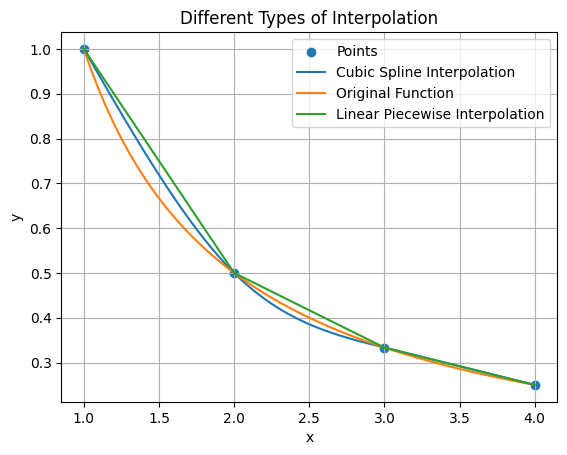

Cubic Spline Coeffient :  [array([ 0.08333333, -0.25      , -0.33333333,  1.5       ]), array([-0.08333333,  0.75      , -2.33333333,  2.83333333]), array([-8.94346325e-18,  1.07321559e-16, -8.33333333e-02,  5.83333333e-01])]
Piece-wise linear Coeffient :  [[-0.5, 1.5], [-0.16666666666666669, 0.8333333333333334], [-0.08333333333333331, 0.5833333333333333]]


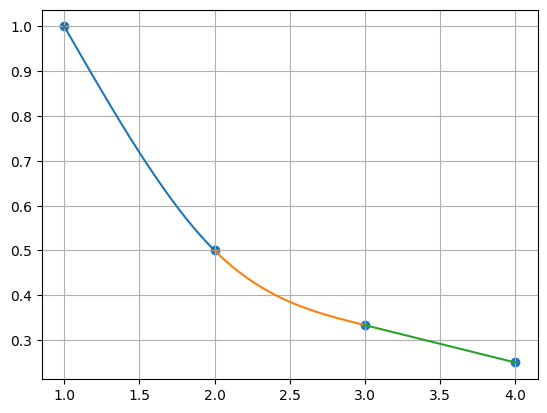

In [21]:
matrix = [(1,1),(2,1/2),(3,1/3),(4,1/4)]
func = lambda x: 1/x
x = []
y = []
n = len(matrix)
for i in range(n):
    x.append(matrix[i][0])
    y.append(matrix[i][1])
ip = Interpolation(matrix,function=func)
coef, poly_list = ip.cubicSpline(matrix,plot_poly=True)
coef_linear,poly_linear = ip.piecewise_linear_interpolation(matrix)
print('Cubic Spline Coeffient : ',coef)
print('Piece-wise linear Coeffient : ',coef_linear)
plt.scatter(x,y)
for i in range(1,len(matrix)):
    x_r = np.linspace(matrix[i-1][0],matrix[i][0],1000)
    y_test = poly_list[i-1](x_r)
    plt.plot(x_r,y_test)
plt.grid()
plt.show()


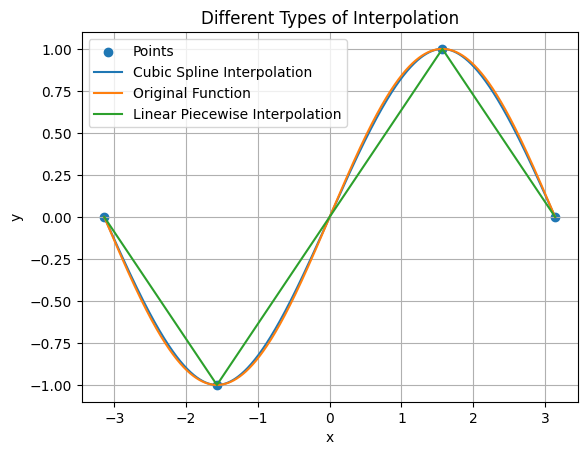

Cubic Spline Coeffient :  [array([0.12900614, 1.2158542 , 2.86478898, 1.        ]), array([-0.12900614,  0.        ,  0.95492966,  0.        ]), array([ 0.12900614, -1.2158542 ,  2.86478898, -1.        ])]
Piece-wise linear Coeffient :  [[-0.6366197723675814, -2.0], [0.6366197723675814, 0.0], [-0.6366197723675814, 2.0]]


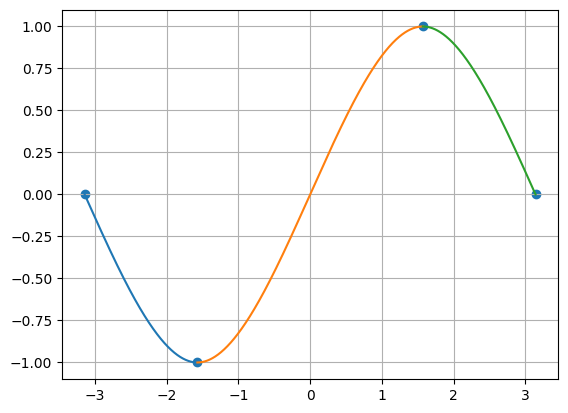

In [20]:
matrix = [(-np.pi,0),(-np.pi/2,-1),(np.pi/2,1),(np.pi,0)]
func = lambda x: np.sin(x)
x = []
y = []
n = len(matrix)
for i in range(n):
    x.append(matrix[i][0])
    y.append(matrix[i][1])
ip = Interpolation(matrix,function=func)
coef, poly_list = ip.cubicSpline(matrix,plot_poly=True)
coef_linear,poly_linear = ip.piecewise_linear_interpolation(matrix)
print('Cubic Spline Coeffient : ',coef)
print('Piece-wise linear Coeffient : ',coef_linear)
plt.scatter(x,y)
for i in range(1,len(matrix)):
    x_r = np.linspace(matrix[i-1][0],matrix[i][0],1000)
    y_test = poly_list[i-1](x_r)
    plt.plot(x_r,y_test)
plt.grid()
plt.show()

# Q2)

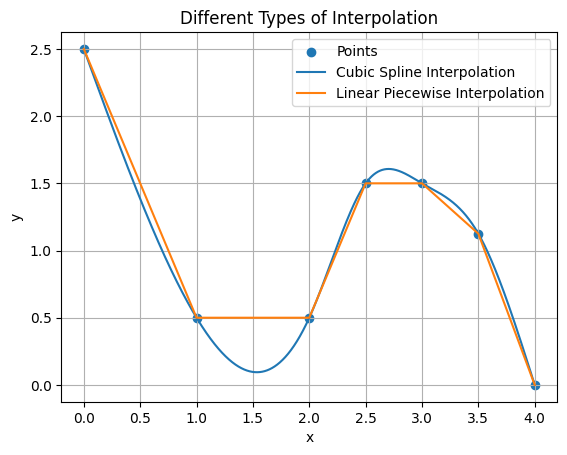

Cubic Spline Coeffient :  [array([ 0.30802048,  0.        , -2.30802048,  2.5       ]), array([ 0.45989761, -0.4556314 , -1.85238908,  2.34812287]), array([ -3.98293515,  26.20136519, -55.16638225,  37.89078498]), array([  2.6996587 , -23.91808874,  70.13225256, -66.52474403]), array([ -1.81569966,  16.72013652, -51.78242321,  55.38993174]), array([  1.56313993, -18.75767918,  72.38993174, -89.4778157 ])]
Piece-wise linear Coeffient :  [[-2.0, 2.5], [0.0, 0.5], [2.0, -3.5], [0.0, 1.5], [-0.75, 3.75], [-2.25, 9.0]]


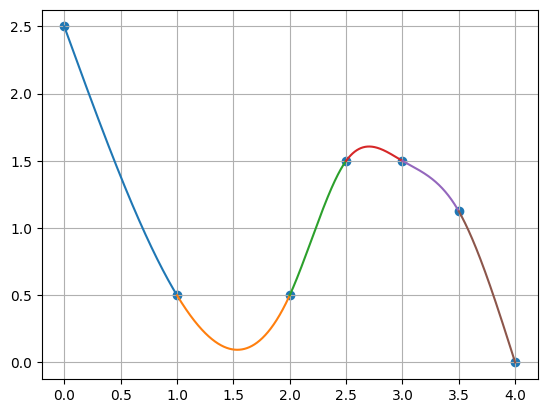

In [19]:
matrix = [(0,2.5),(1,0.5),(2,0.5),(2.5,1.5),(3,1.5),(3.5,1.125),(4,0)]
x = []
y = []
n = len(matrix)
for i in range(n):
    x.append(matrix[i][0])
    y.append(matrix[i][1])
ip = Interpolation(matrix)
coef, poly_list = ip.cubicSpline(matrix,plot_poly=True)
coef_linear,poly_linear = ip.piecewise_linear_interpolation(matrix)
print('Cubic Spline Coeffient : ',coef)
print('Piece-wise linear Coeffient : ',coef_linear)
#print(coef)
plt.scatter(x,y)
for i in range(1,len(matrix)):
    x_r = np.linspace(matrix[i-1][0],matrix[i][0],1000)
    y_test = poly_list[i-1](x_r)
    plt.plot(x_r,y_test)
plt.grid()
plt.show()

# Q3)

3a)

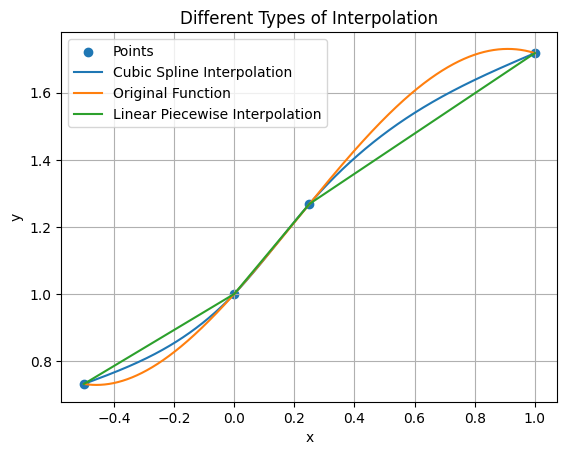

Cubic Spline Coeffient :  [array([0.81141333, 1.21712   , 0.94264467, 1.        ]), array([-2.77319467,  1.21712   ,  0.94264467,  1.        ]), array([ 0.383456  , -1.150368  ,  1.53451667,  0.95067733])]
Piece-wise linear Coeffient :  [[0.5369379999999999, 1.0], [1.0735999999999999, 1.0], [0.5998426666666669, 1.1184393333333333]]


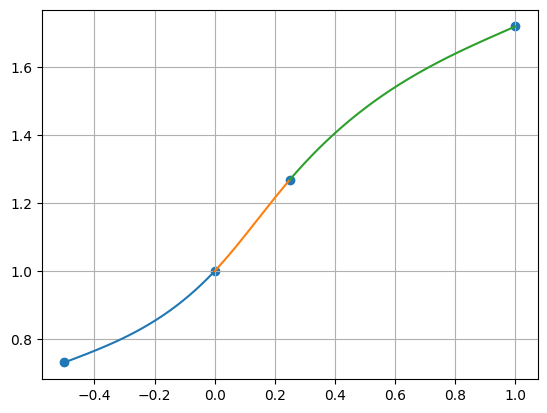

In [22]:
matrix = [(-0.5,0.731531),(0,1),(0.25,1.2684),(1,1.718282)]
func = lambda x: np.exp(x) - x**3
x = []
y = []
n = len(matrix)
for i in range(n):
    x.append(matrix[i][0])
    y.append(matrix[i][1])
ip = Interpolation(matrix,function=func)
coef, poly_list = ip.cubicSpline(matrix,plot_poly=True)
coef_linear,poly_linear = ip.piecewise_linear_interpolation(matrix)
print('Cubic Spline Coeffient : ',coef)
print('Piece-wise linear Coeffient : ',coef_linear)
#print(coef)
plt.scatter(x,y)
for i in range(1,len(matrix)):
    x_r = np.linspace(matrix[i-1][0],matrix[i][0],1000)
    y_test = poly_list[i-1](x_r)
    plt.plot(x_r,y_test)
plt.grid()
plt.show()

3b)

Maximum error in cubic spline : 0.07906998823829414


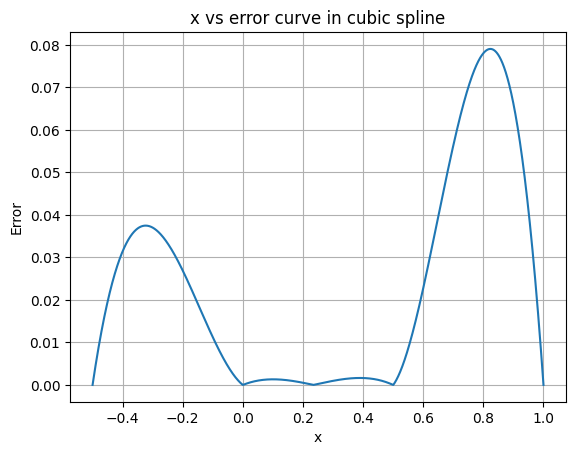

In [25]:
err = []

for i in range(1,len(matrix)):
    x_r = np.linspace(matrix[i-1][0],matrix[i][0],1000)
    y_test = poly_list[i-1](x_r)
    err.append(abs(y_test - func(x_r)))
err = np.array(err)
err = err.reshape((1000*(n-1),))
x_r = np.linspace(matrix[0][0],matrix[-1][0],1000*(n-1))
print('Maximum error in cubic spline :',np.max(err))
plt.plot(x_r,err)
plt.grid()
plt.xlabel('x')
plt.ylabel('Error')
plt.title('x vs error curve in cubic spline')
plt.show()